# Hubert Stefanski - Data Mining II - Main Assignment
## 20081102@mail.wit.ie

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from IPython.display import display, Markdown
plt.style.use("seaborn-darkgrid")
pd.set_option('display.max_columns', None)  

import os
for d in ['data','output']: os.makedirs(d, exist_ok=True)

## Helper functions and globals

In [2]:

def name_func(df):
    col_names = []
    for i in range(df.shape[1]):
        col_names.append("Col_" + str(i))
    return col_names

DEBUG = False
SEED = 64
TARGET = "Target"

## Load Datasets

In [3]:
# Load and name columns, change last column name to "Target"
df = pd.read_csv("data/labeled.csv.gz",names = name_func(pd.read_csv("data/labeled.csv.gz")))
df.columns = [*df.columns[:-1],TARGET]
print("Labeled", df.shape)
# df_labeled.head()

# Load and name columns
df_scoring = pd.read_csv("data/scoring.csv.gz",names = name_func(pd.read_csv("data/scoring.csv.gz")))
print("Scoring", df_scoring.shape)
# df_scoring.head()
                         

Labeled (16000, 177)
Scoring (9000, 176)


### Preliminary analysis

In [4]:
df.shape

(16000, 177)

In [5]:
df.head(5)

,Col_0,Col_1,Col_2,Col_3,Col_4,Col_5,Col_6,Col_7,Col_8,Col_9,Col_10,Col_11,Col_12,Col_13,Col_14,Col_15,Col_16,Col_17,Col_18,Col_19,Col_20,Col_21,Col_22,Col_23,Col_24,Col_25,Col_26,Col_27,Col_28,Col_29,Col_30,Col_31,Col_32,Col_33,Col_34,Col_35,Col_36,Col_37,Col_38,Col_39,Col_40,Col_41,Col_42,Col_43,Col_44,Col_45,Col_46,Col_47,Col_48,Col_49,Col_50,Col_51,Col_52,Col_53,Col_54,Col_55,Col_56,Col_57,Col_58,Col_59,Col_60,Col_61,Col_62,Col_63,Col_64,Col_65,Col_66,Col_67,Col_68,Col_69,Col_70,Col_71,Col_72,Col_73,Col_74,Col_75,Col_76,Col_77,Col_78,Col_79,Col_80,Col_81,Col_82,Col_83,Col_84,Col_85,Col_86,Col_87,Col_88,Col_89,Col_90,Col_91,Col_92,Col_93,Col_94,Col_95,Col_96,Col_97,Col_98,Col_99,Col_100,Col_101,Col_102,Col_103,Col_104,Col_105,Col_106,Col_107,Col_108,Col_109,Col_110,Col_111,Col_112,Col_113,Col_114,Col_115,Col_116,Col_117,Col_118,Col_119,Col_120,Col_121,Col_122,Col_123,Col_124,Col_125,Col_126,Col_127,Col_128,Col_129,Col_130,Col_131,Col_132,Col_133,Col_134,Col_135,Col_136,Col_137,Col_138,Col_139,Col_140,Col_141,Col_142,Col_143,Col_144,Col_145,Col_146,Col_147,Col_148,Col_149,Col_150,Col_151,Col_152,Col_153,Col_154,Col_155,Col_156,Col_157,Col_158,Col_159,Col_160,Col_161,Col_162,Col_163,Col_164,Col_165,Col_166,Col_167,Col_168,Col_169,Col_170,Col_171,Col_172,Col_173,Col_174,Col_175,Target
0,127.2792,2.1250,0.0089,0.000000,0,1.0856,0.8347,2,67.0820,1.0901,0.0133,6,1.2049,0.0,4956.4503,700.3571,0.900,3,0.63,0.1467,5667.93,3.0673,1.0,0.000140,84.8528,yes,0.0507,0.0,yes,3.0,0.002192,0.54,0.00,0.00,0.00,0.001548,0.0,0.2970,3.0,18.6663,no,no,3.15,0.000072,0.0,2,1.26,0.0844,19.1795,26.1972,67.082,1,0.2041,1.1347,0.0000,2005,6.3,0.0044,1861.1658,0.0,1.1258,0.003336,84.8528,3,0.0000,0.0867,19.1707,1.1214,1.62,0.00028,0.0,12.0810,0.024,0.0,no,84.8528,0.031492,15951.33,0.81,2.3,0.000028,3,0.4329,917.48,0.0,0.0592,0.0453,0.0,141.3693,0.0489,0.90,40.6461,2.1111,6.7931,NaN,0.0000,yes,0.708948,1,2.9167,0.0,0.0000,1.1001,0.0,4,1.0699,0.0000,1.3556,8.3191,1.1098,11.070,0.000,708.57,0.1022,1.0847,no,0,4.5882,1.8910,75.06,34.83,0.251908,0.000,6,0.2053,2,1.5000,0.00,7.8250,11.7621,1.1214,907.9648,40.2680,34.1960,1.0333,0.0,0.0,0.0000,1.5600,914,3.0,49.32,0.810,0.0000,0.000000,0.0,0.0000,1.26,0.0900,0.000056,yes,5.0,0.00,0.0,0.990,1152.5624,2.0,4,0.63,1.0427,no,0.0000,0.0,0.0222,0.0900,0.0,0.0089,0.63,YES,0.0,1.0858,0.0,3.0,0.0000,0.0000,5,0
1,90.0000,27.8151,0.8178,0.000024,0,1.1216,0.0453,2,84.8528,0.0000,0.1867,5,1.1206,0.0,184.5735,4410.4081,0.675,2,27.45,0.2533,15250.41,0.0000,1.0,0.009880,60.0000,yes,0.1653,0.0,no,3.0,0.000000,0.00,0.54,0.54,0.81,0.000060,0.0,23.9751,3.0,19.6452,no,no,222.30,0.000264,0.0,2,0.00,0.0000,19.1315,17.9053,67.082,1,0.0000,1.1289,1.5414,2004,0.0,0.0844,205.1430,0.0,1.1141,0.000396,60.0000,2,1.9359,3.7533,18.7933,1.0945,5.94,0.00000,0.0,1.0206,0.788,0.0,yes,0.0000,0.033176,5908.32,1.17,0.6,0.001220,3,0.4702,1269.60,0.0,0.0696,8.7413,0.0,745.9945,0.0000,0.99,38.7104,3.6471,5.1000,5.0,0.0000,yes,0.262592,1,14.3000,0.0,1.0831,1.0892,0.0,4,0.0000,0.0187,0.3333,0.0000,1.1337,1.035,28.260,746.46,0.0089,1.1046,yes,0,0.0000,0.0450,8.91,1.35,0.677796,67.082,5,0.0000,2,8.5143,14.22,2.1250,40.0762,1.1141,0.0000,26.2787,37.5227,0.2720,0.0,0.0,155.7775,0.7111,1272,3.0,0.00,1.125,0.0356,0.000632,0.0,0.0044,314.10,0.2004,0.013960,yes,5.0,0.00,0.0,0.675,212.1320,2.0,3,0.72,0.0000,no,4.6538,1.4,0.0267,3.8032,0.0,0.0222,0.90,yes,0.0,1.1100,0.0,3.0,1.0747,0.3227,5,0
2,0.0000,57.5814,2.7556,0.000000,0,1.1581,0.3973,2,60.0000,0.0000,0.0000,5,1.2339,0.0,67.0820,120.0000,0.900,2,0.00,0.2044,12095.64,0.0000,1.0,0.000000,90.0000,yes,0.0000,0.0,yes,3.0,0.000000,0.00,0.00,0.00,0.00,0.000740,0.0,0.0000,3.0,21.9022,no,no,0.00,0.000000,0.0,2,0.00,0.0000,44.3260,52.6417,67.082,1,0.0000,1.1899,0.0000,2002,0.0,0.0000,113.9297,0.0,1.1355,0.039532,60.0000,2,0.0000,0.0000,15.7787,1.1283,0.00,0.00000,0.0,46.9860,0.000,0.0,no,0.0000,0.023440,2248.65,0.00,0.7,0.000000,3,0.6096,1381.98,0.0,0.0710,83.1013,0.0,261.7626,0.0000,1.35,38.5000,0.0000,22.5879,5.0,0.0

In [6]:
df.dtypes.value_counts()

float64    149
int64       18
object      10
dtype: int64

In [7]:
df_na = df.isna().sum()
df_na[df_na > 0].index 


Index(['Col_22', 'Col_29', 'Col_38', 'Col_94', 'Col_140', 'Col_151', 'Col_156',
       'Col_172'],
      dtype='object')

In [8]:
df.select_dtypes("int64").nunique().sort_values()

Target        2
Col_7         4
Col_125       4
Col_51        4
Col_63        4
Col_175       4
Col_98        4
Col_55        5
Col_157       6
Col_123       6
Col_81        6
Col_45        6
Col_17        6
Col_104       6
Col_11        7
Col_116      14
Col_4        27
Col_139    1224
dtype: int64

### Explicitly cleanup Col_4 and Col_139, they have too many values to be simply categorical

In [9]:
df.Col_4 = df.Col_4.astype(float)
df.Col_139 = df.Col_139.astype(float)

Dataset is a mixture of categorical and numerical data, this will have to be cleaned up to exclude or encode categoricals.

The dataset also seems to have a lot of empty columns, It might be possible that they will affect the score, this will have to be checked again after building the model, then eventually removing columns to test the difference, no point doing so in the cleanup for now.
There are also missing values 

## Cleanup
Cleanup the dataset to mitigate the issues mentioned above, mainly:
- Encode categorical to binary flags
- Drop NaNs and Nulls

In [10]:
def cleanup(df):
    # Changing categorical data to a binary flag, 
    for col in df.select_dtypes(include=['object']).copy():
         # Ensure all strings are lower before encoding
        df[col] = df[col].str.lower()
        encoder = OrdinalEncoder(categories=[['no','yes']])
        df[col] = encoder.fit_transform(df.loc[:,[col]])

    # Check whether NaNs exist
    print("Nan exists?: " + str(df.isnull().values.any()))

    # Check total number of NaNs
    print("NaN count: " + str(df.isnull().sum().sum()))

    # Cleanup NaNs
    for col in df.columns:
        if df[col].isna().values.any():
            # Replace all NaNs with mode of the column
            df[col] = df[col].fillna(df[col].mode().values[0])

   
        # Check whether NaNs exist after nan Cleanup      
    print("Nan exists?: " + str(df.isnull().values.any()))
    # Check total number of NaNs
    print("NaN count: " + str(df.isnull().sum().sum()))
    
    return df
df = cleanup(df)

Nan exists?: True
NaN count: 3365
Nan exists?: False
NaN count: 0


### Post-Cleanup check
Datatypes were corrected in the cleanup() function, ensure that there is no categorical data left

In [11]:
df

,Col_0,Col_1,Col_2,Col_3,Col_4,Col_5,Col_6,Col_7,Col_8,Col_9,Col_10,Col_11,Col_12,Col_13,Col_14,Col_15,Col_16,Col_17,Col_18,Col_19,Col_20,Col_21,Col_22,Col_23,Col_24,Col_25,Col_26,Col_27,Col_28,Col_29,Col_30,Col_31,Col_32,Col_33,Col_34,Col_35,Col_36,Col_37,Col_38,Col_39,Col_40,Col_41,Col_42,Col_43,Col_44,Col_45,Col_46,Col_47,Col_48,Col_49,Col_50,Col_51,Col_52,Col_53,Col_54,Col_55,Col_56,Col_57,Col_58,Col_59,Col_60,Col_61,Col_62,Col_63,Col_64,Col_65,Col_66,Col_67,Col_68,Col_69,Col_70,Col_71,Col_72,Col_73,Col_74,Col_75,Col_76,Col_77,Col_78,Col_79,Col_80,Col_81,Col_82,Col_83,Col_84,Col_85,Col_86,Col_87,Col_88,Col_89,Col_90,Col_91,Col_92,Col_93,Col_94,Col_95,Col_96,Col_97,Col_98,Col_99,Col_100,Col_101,Col_102,Col_103,Col_104,Col_105,Col_106,Col_107,Col_108,Col_109,Col_110,Col_111,Col_112,Col_113,Col_114,Col_115,Col_116,Col_117,Col_118,Col_119,Col_120,Col_121,Col_122,Col_123,Col_124,Col_125,Col_126,Col_127,Col_128,Col_129,Col_130,Col_131,Col_132,Col_133,Col_134,Col_135,Col_136,Col_137,Col_138,Col_139,Col_140,Col_141,Col_142,Col_143,Col_144,Col_145,Col_146,Col_147,Col_148,Col_149,Col_150,Col_151,Col_152,Col_153,Col_154,Col_155,Col_156,Col_157,Col_158,Col_159,Col_160,Col_161,Col_162,Col_163,Col_164,Col_165,Col_166,Col_167,Col_168,Col_169,Col_170,Col_171,Col_172,Col_173,Col_174,Col_175,Target
0,127.2792,2.1250,0.0089,0.000000,0.0,1.0856,0.8347,2,67.0820,1.0901,0.0133,6,1.2049,0.0000,4956.4503,700.3571,0.900,3,0.63,0.1467,5667.93,3.0673,1.0,0.000140,84.8528,1.0,0.0507,0.0,1.0,3.0,0.002192,0.54,0.000,0.00,0.00,0.001548,0.000000,0.2970,3.0,18.6663,0.0,0.0,3.15,0.000072,0.0000,2,1.260,0.0844,19.1795,26.1972,67.0820,1,0.2041,1.1347,0.0000,2005,6.30,0.0044,1861.1658,0.0,1.1258,0.003336,84.8528,3,0.0000,0.0867,19.1707,1.1214,1.62,0.000280,0.0,12.0810,0.024,0.0000,0.0,84.8528,0.031492,15951.33,0.81,2.3,0.000028,3,0.4329,917.48,0.0,0.0592,0.0453,0.00,141.3693,0.0489,0.90,40.6461,2.1111,6.7931,5.0,0.0000,1.0,0.708948,1,2.9167,0.0000,0.0000,1.1001,0.000,4,1.0699,0.0000,1.3556,8.3191,1.1098,11.070,0.000,708.57,0.1022,1.0847,0.0,0,4.5882,1.8910,75.06,34.83,0.251908,0.000,6,0.2053,2,1.5000,0.00,7.8250,11.7621,1.1214,907.9648,40.2680,34.1960,1.0333,0.0000,0.0,0.0000,1.5600,914.0,3.0,49.32,0.810,0.0000,0.000000,0.0000,0.0000,1.26,0.0900,0.000056,1.0,5.0,0.0000,0.0,0.990,1152.5624,2.0,4,0.63,1.0427,0.0,0.0000,0.0000,0.0222,0.0900,0.0,0.0089,0.63,1.0,0.0,1.0858,0.0,3.0,0.0000,0.0000,5,0
1,90.0000,27.8151,0.8178,0.000024,0.0,1.1216,0.0453,2,84.8528,0.0000,0.1867,5,1.1206,0.0000,184.5735,4410.4081,0.675,2,27.45,0.2533,15250.41,0.0000,1.0,0.009880,60.0000,1.0,0.1653,0.0,0.0,3.0,0.000000,0.00,0.540,0.54,0.81,0.000060,0.000000,23.9751,3.0,19.6452,0.0,0.0,222.30,0.000264,0.0000,2,0.000,0.0000,19.1315,17.9053,67.0820,1,0.0000,1.1289,1.5414,2004,0.00,0.0844,205.1430,0.0,1.1141,0.000396,60.0000,2,1.9359,3.7533,18.7933,1.0945,5.94,0.000000,0.0,1.0206,0.788,0.0000,1.0,0.0000,0.033176,5908.32,1.17,0.6,0.001220,3,0.4702,1269.60,0.0,0.0696,8.7413,0.00,745.9945,0.0000,0.99,38.7104,3.6471,5.1000,5.0,0.0000,1.0,0.262592,1,14.3000,0.0000,1.0831,1.0892,0.000,4,0.0000,0.0187,0.3333,0.0000,1.1337,1.035,28.260,746.46,0.0089,1.1046,1.0,0,0.0000,0.0450,8.91,1.35,0.677796,67.082,5,0.0000,2,8.5143,14.22,2.1250,40.0762,1.1141,0.0000,26.2787,37.5227,0.2720,0.0000,0.0,155.7775,0.7111,1272.0,3.0,0.00,1.125,0.0356,0.000632,0.0000,0.0044,314.10,0.2004,0.013960,1.0,5.0,0.0000,0.0,0.675,212.1320,2.0,3,0.72,0.0000,0.0,4.6538,1.4000,0.0267,3.8032,0.0,0.0222,0.90,1.0,0.0,1.1100,0.0,3.0,1.0747,0.3227,5,0
2,0.0000,57.5814,2.7556,0.000000,0.0,1.1581,0.3973,2,60.0000,0.0000,0.0000,5,1.2339,0.0000,67.0820,120.0000,0.900,2,0.00,0.2044,12095.64,0.0000,1.0,0.000000,90.0000,1.0,0.0000,0.0,1.0,3.0,0.000000,0.00,0.000,0.00,0.00,0.000740,0.000000,0.0000,3.0,21.9022,0.0,0.0,0.00,0.000000,0.0000,2,0.000,0.0000,44.3260,52.6417,67.0820,1,0.0000,1.1899,0.0000,2002,0.00,0.0000,113.9297,0.0,1.1355,0.039532,60.0000,2,0.0000,0.0000,15.7787,1.1283,0.00,0.000000,0.0,46.9860,0.000,0.0000,0.0,0.0000,0.023440,2248

In [12]:
df.dtypes.value_counts()

float64    161
int64       16
dtype: int64

In [13]:
df_na = df.isna().sum()
df_na[df_na > 0].index 

Index([], dtype='object')

No more categoricals or na, nice.

In [14]:
df.shape

(16000, 177)

In [15]:
df.head(5)

,Col_0,Col_1,Col_2,Col_3,Col_4,Col_5,Col_6,Col_7,Col_8,Col_9,Col_10,Col_11,Col_12,Col_13,Col_14,Col_15,Col_16,Col_17,Col_18,Col_19,Col_20,Col_21,Col_22,Col_23,Col_24,Col_25,Col_26,Col_27,Col_28,Col_29,Col_30,Col_31,Col_32,Col_33,Col_34,Col_35,Col_36,Col_37,Col_38,Col_39,Col_40,Col_41,Col_42,Col_43,Col_44,Col_45,Col_46,Col_47,Col_48,Col_49,Col_50,Col_51,Col_52,Col_53,Col_54,Col_55,Col_56,Col_57,Col_58,Col_59,Col_60,Col_61,Col_62,Col_63,Col_64,Col_65,Col_66,Col_67,Col_68,Col_69,Col_70,Col_71,Col_72,Col_73,Col_74,Col_75,Col_76,Col_77,Col_78,Col_79,Col_80,Col_81,Col_82,Col_83,Col_84,Col_85,Col_86,Col_87,Col_88,Col_89,Col_90,Col_91,Col_92,Col_93,Col_94,Col_95,Col_96,Col_97,Col_98,Col_99,Col_100,Col_101,Col_102,Col_103,Col_104,Col_105,Col_106,Col_107,Col_108,Col_109,Col_110,Col_111,Col_112,Col_113,Col_114,Col_115,Col_116,Col_117,Col_118,Col_119,Col_120,Col_121,Col_122,Col_123,Col_124,Col_125,Col_126,Col_127,Col_128,Col_129,Col_130,Col_131,Col_132,Col_133,Col_134,Col_135,Col_136,Col_137,Col_138,Col_139,Col_140,Col_141,Col_142,Col_143,Col_144,Col_145,Col_146,Col_147,Col_148,Col_149,Col_150,Col_151,Col_152,Col_153,Col_154,Col_155,Col_156,Col_157,Col_158,Col_159,Col_160,Col_161,Col_162,Col_163,Col_164,Col_165,Col_166,Col_167,Col_168,Col_169,Col_170,Col_171,Col_172,Col_173,Col_174,Col_175,Target
0,127.2792,2.1250,0.0089,0.000000,0.0,1.0856,0.8347,2,67.0820,1.0901,0.0133,6,1.2049,0.0,4956.4503,700.3571,0.900,3,0.63,0.1467,5667.93,3.0673,1.0,0.000140,84.8528,1.0,0.0507,0.0,1.0,3.0,0.002192,0.54,0.00,0.00,0.00,0.001548,0.0,0.2970,3.0,18.6663,0.0,0.0,3.15,0.000072,0.0,2,1.26,0.0844,19.1795,26.1972,67.082,1,0.2041,1.1347,0.0000,2005,6.3,0.0044,1861.1658,0.0,1.1258,0.003336,84.8528,3,0.0000,0.0867,19.1707,1.1214,1.62,0.00028,0.0,12.0810,0.024,0.0,0.0,84.8528,0.031492,15951.33,0.81,2.3,0.000028,3,0.4329,917.48,0.0,0.0592,0.0453,0.0,141.3693,0.0489,0.90,40.6461,2.1111,6.7931,5.0,0.0000,1.0,0.708948,1,2.9167,0.0,0.0000,1.1001,0.0,4,1.0699,0.0000,1.3556,8.3191,1.1098,11.070,0.000,708.57,0.1022,1.0847,0.0,0,4.5882,1.8910,75.06,34.83,0.251908,0.000,6,0.2053,2,1.5000,0.00,7.8250,11.7621,1.1214,907.9648,40.2680,34.1960,1.0333,0.0,0.0,0.0000,1.5600,914.0,3.0,49.32,0.810,0.0000,0.000000,0.0,0.0000,1.26,0.0900,0.000056,1.0,5.0,0.00,0.0,0.990,1152.5624,2.0,4,0.63,1.0427,0.0,0.0000,0.0,0.0222,0.0900,0.0,0.0089,0.63,1.0,0.0,1.0858,0.0,3.0,0.0000,0.0000,5,0
1,90.0000,27.8151,0.8178,0.000024,0.0,1.1216,0.0453,2,84.8528,0.0000,0.1867,5,1.1206,0.0,184.5735,4410.4081,0.675,2,27.45,0.2533,15250.41,0.0000,1.0,0.009880,60.0000,1.0,0.1653,0.0,0.0,3.0,0.000000,0.00,0.54,0.54,0.81,0.000060,0.0,23.9751,3.0,19.6452,0.0,0.0,222.30,0.000264,0.0,2,0.00,0.0000,19.1315,17.9053,67.082,1,0.0000,1.1289,1.5414,2004,0.0,0.0844,205.1430,0.0,1.1141,0.000396,60.0000,2,1.9359,3.7533,18.7933,1.0945,5.94,0.00000,0.0,1.0206,0.788,0.0,1.0,0.0000,0.033176,5908.32,1.17,0.6,0.001220,3,0.4702,1269.60,0.0,0.0696,8.7413,0.0,745.9945,0.0000,0.99,38.7104,3.6471,5.1000,5.0,0.0000,1.0,0.262592,1,14.3000,0.0,1.0831,1.0892,0.0,4,0.0000,0.0187,0.3333,0.0000,1.1337,1.035,28.260,746.46,0.0089,1.1046,1.0,0,0.0000,0.0450,8.91,1.35,0.677796,67.082,5,0.0000,2,8.5143,14.22,2.1250,40.0762,1.1141,0.0000,26.2787,37.5227,0.2720,0.0,0.0,155.7775,0.7111,1272.0,3.0,0.00,1.125,0.0356,0.000632,0.0,0.0044,314.10,0.2004,0.013960,1.0,5.0,0.00,0.0,0.675,212.1320,2.0,3,0.72,0.0000,0.0,4.6538,1.4,0.0267,3.8032,0.0,0.0222,0.90,1.0,0.0,1.1100,0.0,3.0,1.0747,0.3227,5,0
2,0.0000,57.5814,2.7556,0.000000,0.0,1.1581,0.3973,2,60.0000,0.0000,0.0000,5,1.2339,0.0,67.0820,120.0000,0.900,2,0.00,0.2044,12095.64,0.0000,1.0,0.000000,90.0000,1.0,0.0000,0.0,1.0,3.0,0.000000,0.00,0.00,0.00,0.00,0.000740,0.0,0.0000,3.0,21.9022,0.0,0.0,0.00,0.000000,0.0,2,0.00,0.0000,44.3260,52.6417,67.082,1,0.0000,1.1899,0.0000,2002,0.0,0.0000,113.9297,0.0,1.1355,0.039532,60.0000,2,0.0000,0.0000,15.7787,1.1283,0.00,0.00000,0.0,46.9860,0.000,0.0,0.0,0.0000,0.023440,2248.65,0.00,0.7,0.000000,3,0.6096,1381.98,0.0,0.0710,83.1013,0.0,261.7626,0.0000,1.35,38.5000,

In [16]:
## Checking for null values
missing_vals = df.isnull().values.sum()
print("Missing values: ", missing_vals)

Missing values:  0


#### Comment:
no need to fix dtypes, all int64 and float64 and no missing values

### Categorical/Numerical split

In [17]:
# Get column names as list
attributes = df.columns.tolist()
# Remove the target column, no point in doing this if we include it
attributes.remove(TARGET)

temp = df[attributes].nunique()

categorical = list(temp[(temp>1)& (temp<20)].index)

numerical = list(temp[(temp>20)].index)

f"Categorical count: {len(categorical)} and Numerical count:{len(numerical)}"

'Categorical count: 29 and Numerical count:143'

## Output the cleaned up DataFrame to a fresh csv
This allows some insight through dTale

In [18]:
# df.to_csv("output/clean_df_labeled.csv", compression='gzip' ,index=False)

### Exploratory Data Analysis
TODO

### Train-Test split

In [19]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, stratify=df[TARGET], test_size=.40, random_state=SEED)

## Checking for null values
missing_vals = df.isnull().values.sum()
print("Missing values: ", missing_vals)
print(df_train.shape,df_test.shape)

Missing values:  0
(9600, 177) (6400, 177)


In [20]:
df_train.head(1)

,Col_0,Col_1,Col_2,Col_3,Col_4,Col_5,Col_6,Col_7,Col_8,Col_9,Col_10,Col_11,Col_12,Col_13,Col_14,Col_15,Col_16,Col_17,Col_18,Col_19,Col_20,Col_21,Col_22,Col_23,Col_24,Col_25,Col_26,Col_27,Col_28,Col_29,Col_30,Col_31,Col_32,Col_33,Col_34,Col_35,Col_36,Col_37,Col_38,Col_39,Col_40,Col_41,Col_42,Col_43,Col_44,Col_45,Col_46,Col_47,Col_48,Col_49,Col_50,Col_51,Col_52,Col_53,Col_54,Col_55,Col_56,Col_57,Col_58,Col_59,Col_60,Col_61,Col_62,Col_63,Col_64,Col_65,Col_66,Col_67,Col_68,Col_69,Col_70,Col_71,Col_72,Col_73,Col_74,Col_75,Col_76,Col_77,Col_78,Col_79,Col_80,Col_81,Col_82,Col_83,Col_84,Col_85,Col_86,Col_87,Col_88,Col_89,Col_90,Col_91,Col_92,Col_93,Col_94,Col_95,Col_96,Col_97,Col_98,Col_99,Col_100,Col_101,Col_102,Col_103,Col_104,Col_105,Col_106,Col_107,Col_108,Col_109,Col_110,Col_111,Col_112,Col_113,Col_114,Col_115,Col_116,Col_117,Col_118,Col_119,Col_120,Col_121,Col_122,Col_123,Col_124,Col_125,Col_126,Col_127,Col_128,Col_129,Col_130,Col_131,Col_132,Col_133,Col_134,Col_135,Col_136,Col_137,Col_138,Col_139,Col_140,Col_141,Col_142,Col_143,Col_144,Col_145,Col_146,Col_147,Col_148,Col_149,Col_150,Col_151,Col_152,Col_153,Col_154,Col_155,Col_156,Col_157,Col_158,Col_159,Col_160,Col_161,Col_162,Col_163,Col_164,Col_165,Col_166,Col_167,Col_168,Col_169,Col_170,Col_171,Col_172,Col_173,Col_174,Col_175,Target
10116,60.0,22.7931,0.6356,0.000516,0.0,1.1447,0.1093,3,94.8683,0.0,0.0889,6,1.1989,0.0,60.0,4467.684,0.63,2,29.7,0.1289,12277.62,0.0,1.0,0.002672,90.0,1.0,0.5813,0.00002,0.0,3.0,0.0,0.63,0.81,11.61,0.0,0.000168,0.0,6.2984,3.0,27.3705,0.0,0.0,60.12,0.001472,0.0,3,0.0,0.0,24.669,26.1543,67.082,1,0.0424,1.1564,1.7731,2005,1.8,0.0756,838.4903,0.0,1.134,0.007164,67.082,2,0.6653,1.1493,19.98,1.1258,33.12,0.00008,0.45,15.698,0.7707,0.0,1.0,0.0,0.02838,9108.9,2.43,4.1,0.00132,4,0.5374,1407.35,0.0044,0.0657,5.28,0.0,425.192,0.0133,0.99,44.5266,5.5897,10.3882,5.0,1374.1179,1.0,0.40484,1,8.7115,0.0,1.048,1.064,0.0,3,1.064,0.224,1.0711,0.0,1.1327,11.7,34.38,638.55,0.0267,1.0861,1.0,0,2.5556,0.2012,161.19,3.78,0.545672,67.082,5,0.0613,2,8.1351,6.03,3.2308,6.4568,1.1176,5590.7155,45.688,49.9053,2.328,0.0,0.45,60.0,1.6222,1402.0,3.0,0.0,0.9,0.0222,0.000268,0.0,0.04,167.13,4.3777,0.007428,1.0,4.0,0.9525,0.0,0.72,60.0,1.0,3,0.72,0.0,0.0,3.3529,3.6522,0.0311,1.509,1.0699,0.0311,1.26,1.0,1.2,1.0993,0.016,2.0,1.1065,0.1413,4,0


### Feature Engineering

In [21]:

ohe = preprocessing.OneHotEncoder(sparse=False, handle_unknown='ignore')

def feature_engineering(df_train,df_test,debug=True):
    df_train_model = pd.DataFrame()
    df_test_model = pd.DataFrame()

    
    for feature in categorical:
        #train
        print("Categorical Features")
        print(f"Train Feature {feature} with {df_train[feature].nunique()} levels")
        X = ohe.fit_transform(df_train[feature].values.reshape(-1,1))
        df_tmp = pd.DataFrame(X, columns = [f"{feature}_{k}" for k in range(X.shape[1])])
        df_train_model = pd.concat([df_train_model, df_tmp], axis=1)

        #test
        print(f"Test Features {feature} with {df_test[feature].nunique()} levels")
        X = ohe.transform(df_test[feature].values.reshape(-1,1))
        df_tmp = pd.DataFrame(X, columns = [f"{feature}_{k}" for k in range(X.shape[1])])
        df_test_model = pd.concat([df_test_model, df_tmp], axis=1)
        
    for feature in numerical:
        if debug:
            print(f"\tFeature {feature}")
        #train
        X =df_train[feature].values
        df_train_model[feature]=X
        df_train_model[f"{feature}_is_zero"] = (X==0).astype("int64")
        df_train_model[f"{feature}_log"] = np.log(X+1)

        #test
        X =df_test[feature].values
        df_test_model[feature]=X
        df_test_model[f"{feature}_is_zero"] = (X==0).astype("int64")
        df_test_model[f"{feature}_log"] = np.log(X+1)
        
        # Add the target back in
        
    df_train_model[TARGET] = df_train[TARGET].values
    if TARGET in df_test.columns:
        df_test_model[TARGET] = df_test[TARGET].values

    print("Train dataset", df_train_model.shape)
    print("Test dataset", df_test_model.shape)

    return df_train_model, df_test_model

df_train_model, df_test_model = feature_engineering(df_train,df_test,debug=False)
 

Categorical Features
Train Feature Col_7 with 4 levels
Test Features Col_7 with 4 levels
Categorical Features
Train Feature Col_11 with 7 levels
Test Features Col_11 with 7 levels
Categorical Features
Train Feature Col_17 with 6 levels
Test Features Col_17 with 6 levels
Categorical Features
Train Feature Col_22 with 4 levels
Test Features Col_22 with 4 levels
Categorical Features
Train Feature Col_25 with 2 levels
Test Features Col_25 with 2 levels
Categorical Features
Train Feature Col_28 with 2 levels
Test Features Col_28 with 2 levels
Categorical Features
Train Feature Col_29 with 4 levels
Test Features Col_29 with 4 levels
Categorical Features
Train Feature Col_38 with 4 levels
Test Features Col_38 with 4 levels
Categorical Features
Train Feature Col_40 with 2 levels
Test Features Col_40 with 2 levels
Categorical Features
Train Feature Col_45 with 6 levels
Test Features Col_45 with 5 levels
Categorical Features
Train Feature Col_51 with 4 levels
Test Features Col_51 with 4 levels
C

## Model Building

#### Data normalization and scaling

In [22]:
from sklearn.preprocessing import StandardScaler

features = df_train_model.columns[:-1]
print("Num of features", len(features))

X_train, y_train = df_train_model[features], df_train_model[TARGET]
X_test, y_test = df_test_model[features],df_test_model[TARGET]

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Num of features 558


In [23]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=1000)

score = model_selection.cross_val_score(model, X_train, y_train, cv=10, n_jobs=-1, scoring='accuracy')


In [24]:
print(f"Accuracy CV mean score is {score.mean():.2%} with a std of {score.std():.2%}")

Accuracy CV mean score is 69.06% with a std of 1.02%


### Feature Selection

In [25]:
models = []

from sklearn.linear_model import LogisticRegression
models.append( {"name": "LogisticRegression", "ref": LogisticRegression(solver="liblinear", max_iter=2000)} )

from sklearn.ensemble import RandomForestClassifier
models.append( {"name": "RT ", "ref": RandomForestClassifier(criterion='entropy', max_depth=4)} )

from sklearn.naive_bayes import GaussianNB
models.append({"name": "GNB ", "ref": GaussianNB()})

print("Models:")
for model in models:
    print(f"    {model['name']:30} {model['ref']}")

Models:
    LogisticRegression             LogisticRegression(max_iter=2000, solver='liblinear')
    RT                             RandomForestClassifier(criterion='entropy', max_depth=4)
    GNB                            GaussianNB()


Optimal number of features : 57


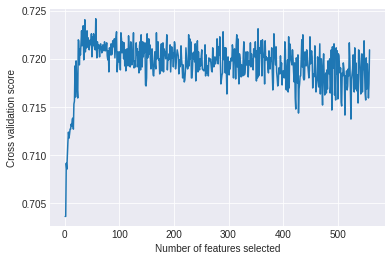

In [26]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

model = models[1]["ref"]

rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(2), scoring="accuracy")
rfecv.fit(X_train, y_train)
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()


### Hyper Parameter Optimisation

In [27]:
from scipy.stats import uniform

# param_range = np.logspace(-4, 4, 9) 

# param_grid = [{
#     'solver': ['newton-cg', 'lbfgs', 'saga'],
#      'C': param_range, 
#     'penalty': ['l2','l1', 'none']
# }]
 

param_grid = [{
    'solver': [ 'saga'],
     'C': 4, 
    'penalty': ['l2','l1']
}]

from sklearn.linear_model import LogisticRegression


cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

model = LogisticRegression(solver='saga', tol=1e-2,max_iter=200,random_state=SEED)
gs = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='accuracy', error_score=0)
gs_result = gs.fit(X_train, y_train)

ValueError: Parameter grid for parameter (C) needs to be a list or numpy array, but got (<class 'int'>). Single values need to be wrapped in a list with one element.

In [ ]:
means = gs_result.cv_results_['mean_test_score']
stds = gs_result.cv_results_['std_test_score']
params = gs_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

## Model Validation

In [ ]:
model = LogisticRegression(solver='saga', tol=1e-2,max_iter=200,random_state=SEED, C=1.6307481123211445,penalty='l1')

model.fit(X_train,y_train)
y_pred = model.predict(X_test)

print("Accuracy:", metrics.accuracy_score(y_test,y_pred))
print(metrics.classification_report(y_test,y_pred,digits-4))


### Scoring -- `accuracy`

In [ ]:
df_labeled = pd.read_csv("data/labeled.csv.gz",names = name_func(pd.read_csv("data/labeled.csv.gz")))
df_labeled.columns = [*df_labeled.columns[:-1],"Target"]

df_labeled = cleanup(df_labeled)
print(df_labeled.shape)
df_labeled.head(1)
df_labeled.dtypes.value_counts()
df_na = df.isna().sum()
f'{df_na[df_na > 0].index} na values'

In [ ]:
df_scoring = pd.read_csv("data/scoring.csv.gz",names = name_func(pd.read_csv("data/scoring.csv.gz")))
df_scoring.columns = [*df_scoring.columns[:-1],"Target"]

df_scoring = cleanup(df_scoring)
print(df_scoring.shape)
df_scoring.head(1)
df_scoring.dtypes.value_counts()


In [ ]:
df_train_model, df_test_model = feature_engineering(df_labeled,df_scoring,False)

ss = preprocessing.StandardScaler()
df_train_model_scaled = ss.fit_transform(df_train_model)
df_test_model_scaled = ss.transform(df_train_model)

In [ ]:
model = LogisticRegrestion(solver='saga',tol=1e-2, max_iter=200, random_state=SEED, C= 1.6307581123211445,penalty='l1')
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

In [ ]:
pd.DataFrame(data=y_pred, columns=['target']).to_scv("pred_accuracy.csv.gz",compression="gzip", index=False)

### Scoring -- `roc_auc`